# Classificatie van warmtepomp-verbruik

Classifiecatiemodel trainen voorspelling warmtepomp modus:

    0 = off
    1 = heat
    2 = water

In [1]:
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from scripts import weather_data_preprocess as wdp


## Data-analyse en samenstellen van de dataset

! SKIP DIT HOOFDSTUK ALS JE NIET BESCHIKT OVER DE RUWE DATA !

### Data inlezen en voorbereiden

In [2]:
# Inlezen van de data
df_heat = pd.read_csv('data/raw/household_JVR_heat.csv')
df_heat.head()

,datetime,heat(kWh)
0,2024-03-14 08:00:00+01:00,8017.324
1,2024-03-14 08:15:00+01:00,8017.365
2,2024-03-14 08:45:00+01:00,8017.488
3,2024-03-14 09:00:00+01:00,8017.525
4,2024-03-14 09:15:00+01:00,8017.561


In [3]:
# Datetime kolom omzetten naar een datetime object
df_heat['datetime'] = (df_heat['datetime'].str.replace(' ', 'T'))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+01:00', ''))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+02:00', ''))
df_heat['datetime'] = pd.to_datetime(df_heat['datetime'], errors='coerce')
print(f"Errors: {df_heat['datetime'].isnull().sum()}")
df_heat = df_heat.dropna(subset=['datetime'])
print(f"Dataset size: {df_heat.size}")
df_heat.tail()

Errors: 1
Dataset size: 84928


,datetime,heat(kWh)
42459,2025-06-11 14:00:00,10225.840
42460,2025-06-11 14:15:00,10225.841
42461,2025-06-11 14:30:00,10225.842
42462,2025-06-11 14:45:00,10225.843
42463,2025-06-11 15:00:00,10225.844


In [4]:
# Eerste en laatste tijdstip in de dataset vinden
first_date = df_heat['datetime'].min()
last_date = df_heat['datetime'].max()
print(f"First date: {first_date}, Last date: {last_date}")

First date: 2024-03-14 08:00:00, Last date: 2025-06-11 15:00:00


In [5]:
# Een nieuwe df aan maken met alle data tussen de eerste en laatste datum
ds_range = pd.date_range(start=first_date, end=last_date, freq='15min')
df_full = pd.DataFrame({'datetime': ds_range})
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43613 entries, 0 to 43612
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  43613 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 340.9 KB


In [6]:
# Meterstanden toevoegen aan de nieuwe dataframe
df_full = df_full.merge(df_heat, on='datetime', how='left')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43617 entries, 0 to 43616
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   43617 non-null  datetime64[ns]
 1   heat(kWh)  42464 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 681.6 KB


In [7]:
# Invullen van de ontbrekende waarden
df_full = df_full.sort_values(by='datetime')
df_full['heat(kWh)'] = df_full['heat(kWh)'].interpolate(method='linear')
df_full = df_full.reset_index(drop=True)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43617 entries, 0 to 43616
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   43617 non-null  datetime64[ns]
 1   heat(kWh)  43617 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 681.6 KB


In [8]:
# Berekenen van het verbruik per 15 minuten
df_full['heat(kWh)'] = (df_full['heat(kWh)'] - df_full['heat(kWh)'].shift(1))
df_full.dropna(subset=['heat(kWh)'], inplace=True)
df_full.head()

,datetime,heat(kWh)
1,2024-03-14 08:15:00,0.0410
2,2024-03-14 08:30:00,0.0615
3,2024-03-14 08:45:00,0.0615
4,2024-03-14 09:00:00,0.0370
5,2024-03-14 09:15:00,0.0360


### Data analyse

Kunnen we een manier vinden om de annotatie van de data te automatiseren? Kan er een patroon gevonden worden waar duidelijk te zien is of de warmtepomp in stand-by staat, actief is voor de verwarming of sanitair?

In [9]:
# Kopiëren van de volledige dataset voor verdere analyse
df_analysis = df_full.copy()

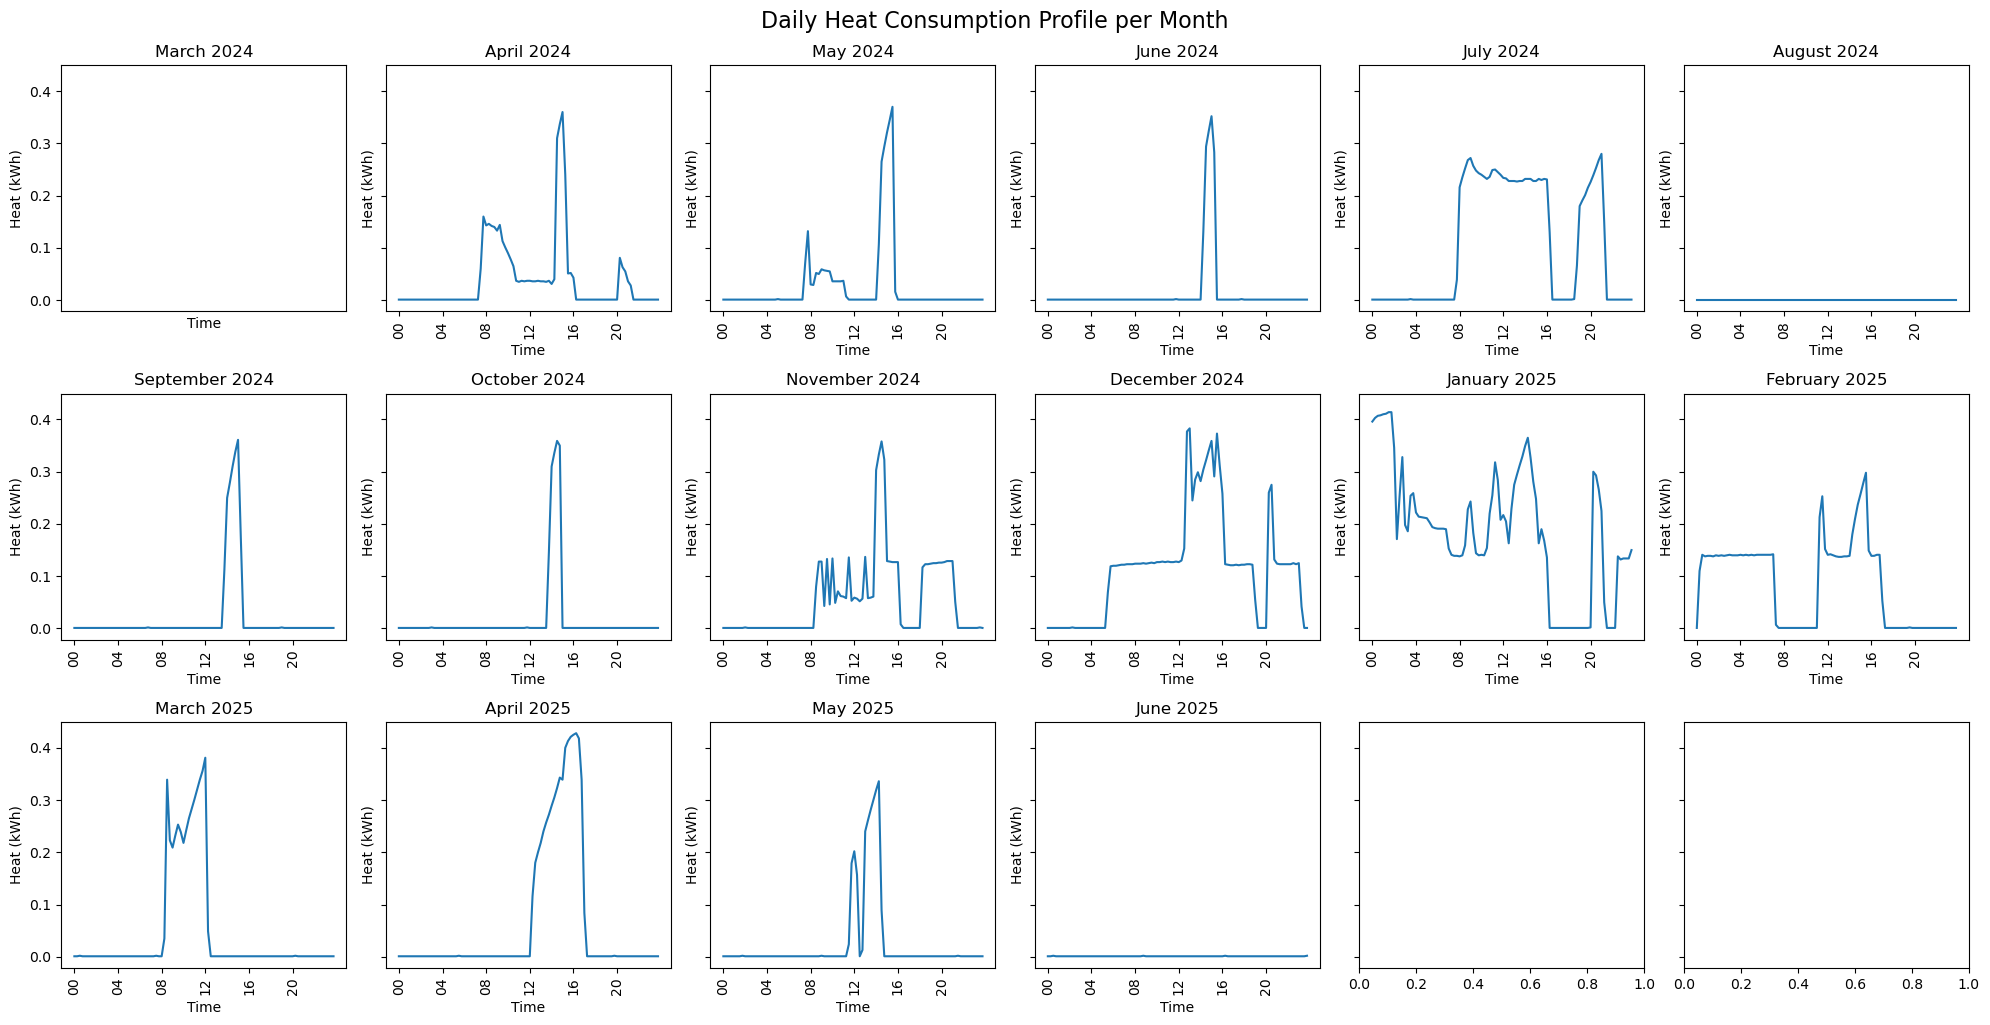

In [10]:
# Plotten van het dagelijks verbruiksprofiel per maand
months = df_analysis['datetime'].dt.to_period('M').unique()
num_cols = 3
num_rows = math.ceil(len(months) / num_cols)

fig, axes = plt.subplots(num_cols, num_rows, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for i, month in enumerate(months):
    day = df_analysis[(df_analysis['datetime'].dt.month == month.month) & 
             (df_analysis['datetime'].dt.year == month.year) & 
             (df_analysis['datetime'].dt.day == 1)]
    axes[i].plot(day['datetime'], day['heat(kWh)'])
    axes[i].set_title(month.strftime('%B %Y'))
    axes[i].set_xlabel('Time')
    tick_indices = range(0, len(day['datetime']), 16)
    axes[i].set_xticks(day['datetime'].iloc[tick_indices])
    axes[i].set_xticklabels(day['datetime'].dt.strftime('%H').iloc[tick_indices], rotation=90)
    axes[i].set_ylabel('Heat (kWh)')

plt.tight_layout()
plt.suptitle('Daily Heat Consumption Profile per Month', fontsize=16, y=1.02)
plt.show()

In [11]:
# Alle data per tijdstip samenvoegen en het gemiddelde berekenen
df_analysis['time'] = df_analysis['datetime'].dt.time
average_values = df_analysis.groupby('time')['heat(kWh)'].mean()
df_average = average_values.reset_index()
df_average['time'] = df_average['time'].astype(str)
df_average = df_average.sort_values(by='time').reset_index(drop=True)

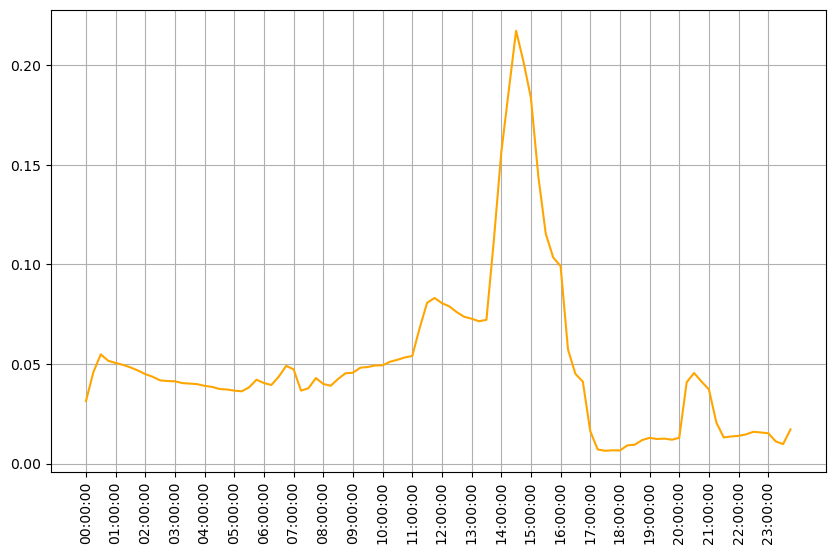

In [12]:
# Visualiseren van de gemiddelde waarden
plt.figure(figsize=(10, 6))
plt.plot(df_average['time'], df_average['heat(kWh)'], label='Visualisatie van de gemiddelde waarden per tijdstip', color='orange')
xticks = df_average['time'][::4]
plt.xticks(xticks, rotation=90)
plt.grid(True, which='both', axis='both')
plt.show()

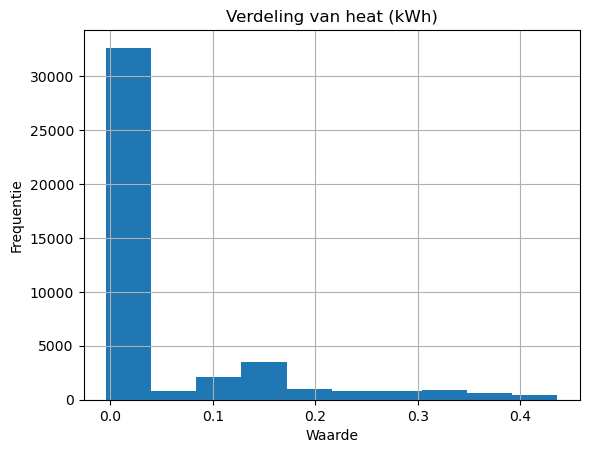

In [13]:
df_analysis['heat(kWh)'].plot(kind='hist')
plt.title('Verdeling van heat (kWh)')
plt.xlabel('Waarde')
plt.ylabel('Frequentie')
plt.grid(True, which='both', axis='both')
plt.show()

### Annoteren van de dataset

We gaan hiervoor K-means clustering gebruiken

In [14]:
# KMeans clustering toepassen
mask = df_full['heat(kWh)'] > 0.05 # Create mask for filtering
df_full['cluster'] = 2
kmeans = KMeans(n_clusters=2, n_init=50, random_state=42)
df_full.loc[mask, 'cluster'] = kmeans.fit_predict(df_full.loc[mask, ['heat(kWh)']])


In [15]:
# Clustercenters bekijken
print("Cluster centers:", kmeans.cluster_centers_)

Cluster centers: [[0.13763692]
 [0.32279025]]


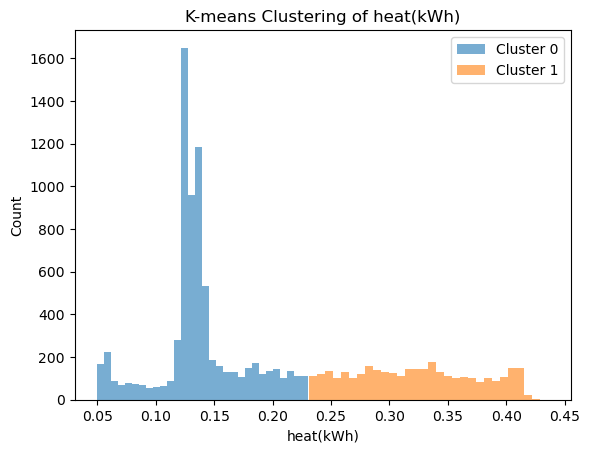

In [16]:
# Visualiseren van de clusters
for i in range(2):
    plt.hist(df_full[df_full['cluster'] == i]['heat(kWh)'], bins=30, alpha=0.6, label=f'Cluster {i}')
plt.xlabel('heat(kWh)')
plt.ylabel('Count')
plt.legend()
plt.title('K-means Clustering of heat(kWh)')
plt.show()


In [17]:
# Wisselen van de clusterlabels voor betere interpretatie
df_full['cluster'] = df_full['cluster'].replace({0:2, 2:0})

In [18]:
df_full['cluster'] = df_full['cluster'].replace({1:2, 2:1})


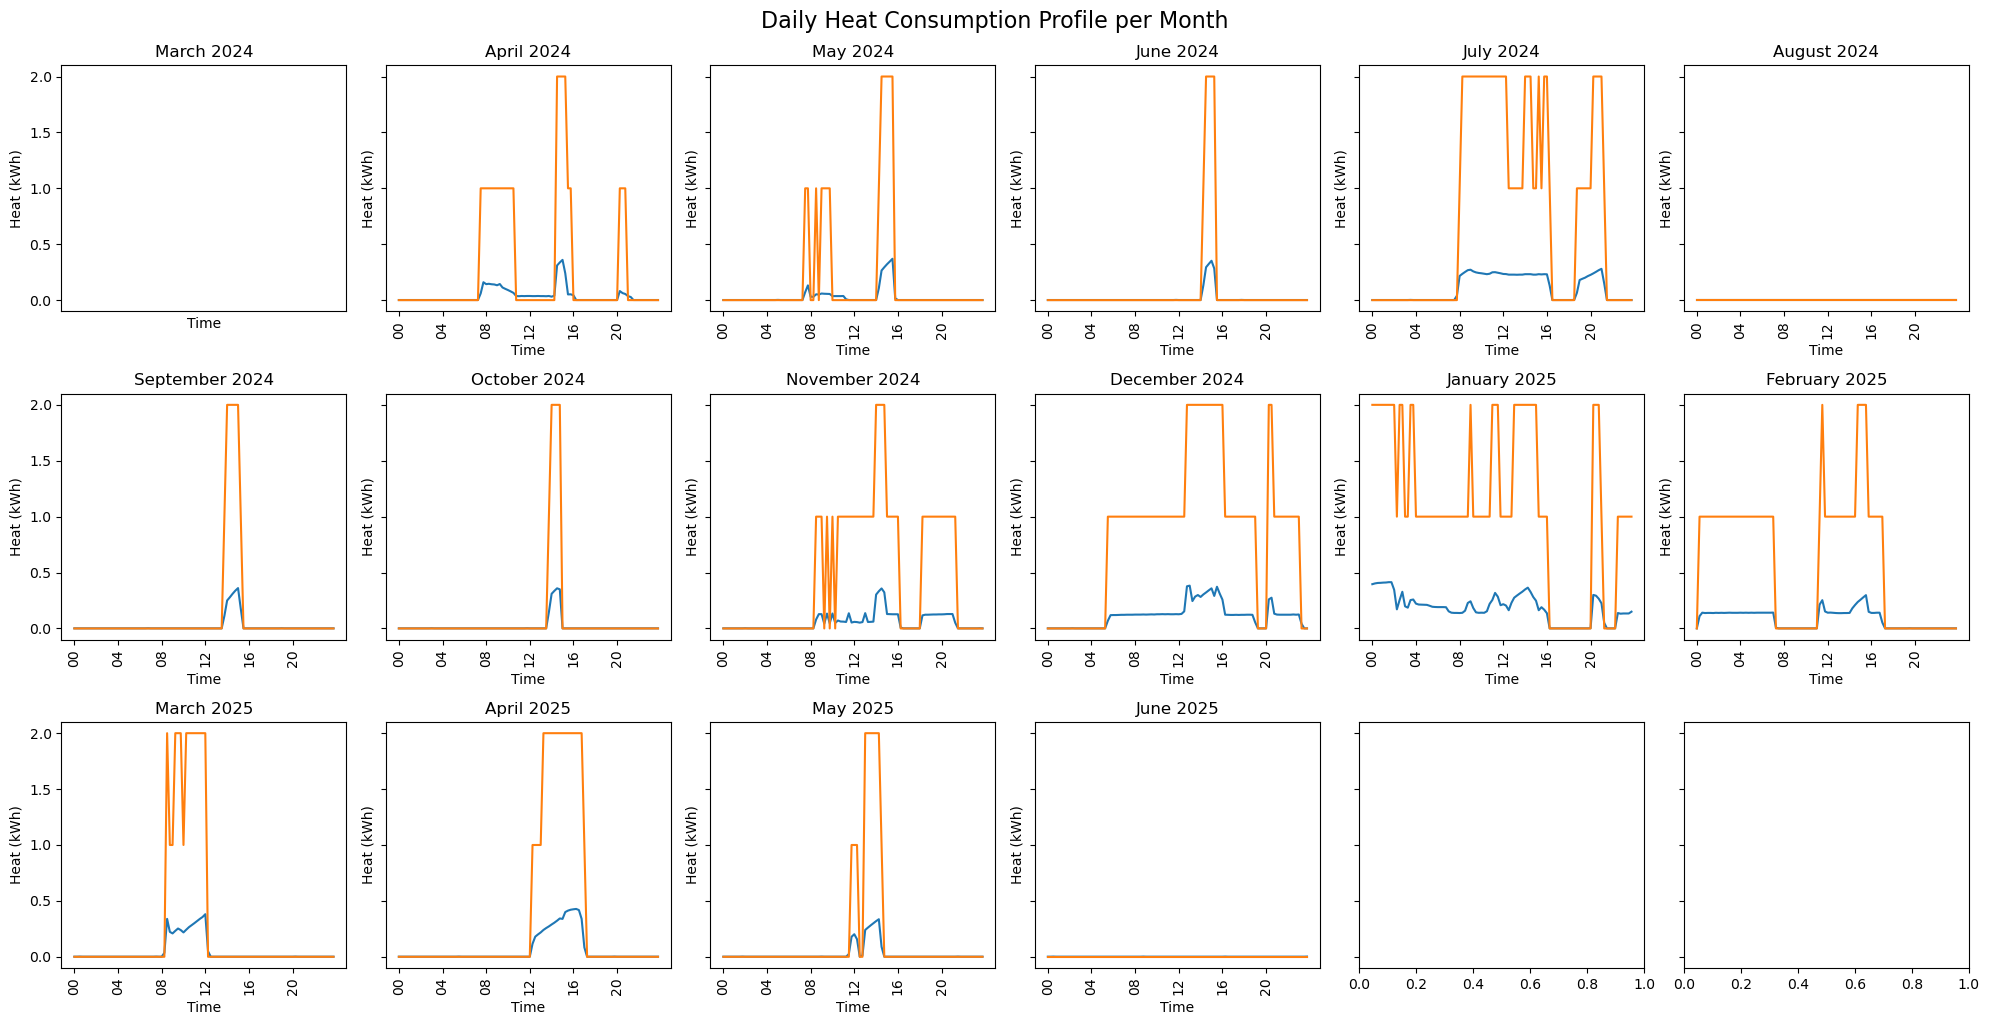

In [19]:
# Plotten van het dagelijks verbruiksprofiel per maand
months = df_full['datetime'].dt.to_period('M').unique()
num_cols = 3
num_rows = math.ceil(len(months) / num_cols)

fig, axes = plt.subplots(num_cols, num_rows, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for i, month in enumerate(months):
    day = df_full[(df_full['datetime'].dt.month == month.month) & 
             (df_full['datetime'].dt.year == month.year) & 
             (df_full['datetime'].dt.day == 1)]
    axes[i].plot(day['datetime'], day['heat(kWh)'])
    axes[i].plot(day['datetime'], day['cluster'])
    axes[i].set_title(month.strftime('%B %Y'))
    axes[i].set_xlabel('Time')
    tick_indices = range(0, len(day['datetime']), 16)
    axes[i].set_xticks(day['datetime'].iloc[tick_indices])
    axes[i].set_xticklabels(day['datetime'].dt.strftime('%H').iloc[tick_indices], rotation=90)
    axes[i].set_ylabel('Heat (kWh)')

plt.tight_layout()
plt.suptitle('Daily Heat Consumption Profile per Month', fontsize=16, y=1.02)
plt.show()

## Bepalen input parameters

In [20]:
# Geef de dag van het jaar, de dag van de week en de tijd van de dag weer als een sinus- en cosinusgolf
df_full['day_of_year'] = df_full['datetime'].dt.dayofyear
df_full['day_of_week'] = df_full['datetime'].dt.dayofweek
df_full['time_of_day'] = df_full['datetime'].dt.hour
# Bereken sinus- en cosinuswaarden voor day_of_year
df_full['day_of_year_sine'] = np.sin(2 * np.pi * df_full['day_of_year'] / 365)
df_full['day_of_year_cosine'] = np.cos(2 * np.pi * df_full['day_of_year'] / 365)
# Bereken sinus- en cosinuswaarden voor day_of_week
df_full['day_of_week_sine'] = np.sin(2 * np.pi * df_full['day_of_week'] / 7)
df_full['day_of_week_cosine'] = np.cos(2 * np.pi * df_full['day_of_week'] / 7)
# Bereken sinus- en cosinuswaarden voor hour_of_day
df_full['hour_of_day_sine'] = np.sin(2 * np.pi * df_full['time_of_day'] / 24)
df_full['hour_of_day_cosine'] = np.cos(2 * np.pi * df_full['time_of_day'] / 24)
df_full = df_full.drop(columns=['day_of_year', 'day_of_week', 'time_of_day'])

In [21]:
# Ruwe weersdata info
weather_data_ingelmunster = [
    'Ingelmunster 2024-03-01 to 2024-03-31.csv',
    'Ingelmunster 2024-04-01 to 2024-04-30.csv',
    'Ingelmunster 2024-05-01 to 2024-05-31.csv',
    'Ingelmunster 2024-06-01 to 2024-06-30.csv',
    'Ingelmunster 2024-07-01 to 2024-07-31.csv',
    'Ingelmunster 2024-08-01 to 2024-08-31.csv',
    'Ingelmunster 2024-09-01 to 2024-09-30.csv',
    'Ingelmunster 2024-10-01 to 2024-10-31.csv',
    'Ingelmunster 2024-11-01 to 2024-11-30.csv',
    'Ingelmunster 2024-12-01 to 2024-12-31.csv',
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
    'Ingelmunster 2025-02-01 to 2025-02-28.csv',
    'Ingelmunster 2025-03-01 to 2025-03-31.csv',
]
ingelmunster_location = [50.920699369528734, 3.2532075343447575]

In [22]:
# Interpoleren van de weergegevens
processor = wdp.WeatherDataPreprocess()
df_weather_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
for file in range(len(weather_data_ingelmunster)):
    print(f'Processing {weather_data_ingelmunster[file]}')
    df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_data_ingelmunster[file])])

Processing Ingelmunster 2024-03-01 to 2024-03-31.csv
Processing Ingelmunster 2024-04-01 to 2024-04-30.csv
Processing Ingelmunster 2024-05-01 to 2024-05-31.csv


/var/folders/yg/5hgw5_z931sd5sx564slbskh0000gq/T/ipykernel_51405/903021607.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_data_ingelmunster[file])])


Processing Ingelmunster 2024-06-01 to 2024-06-30.csv
Processing Ingelmunster 2024-07-01 to 2024-07-31.csv
Processing Ingelmunster 2024-08-01 to 2024-08-31.csv
Processing Ingelmunster 2024-09-01 to 2024-09-30.csv
Processing Ingelmunster 2024-10-01 to 2024-10-31.csv
Processing Ingelmunster 2024-11-01 to 2024-11-30.csv
Processing Ingelmunster 2024-12-01 to 2024-12-31.csv
Processing Ingelmunster 2025-01-01 to 2025-01-31.csv
Processing Ingelmunster 2025-02-01 to 2025-02-28.csv
Processing Ingelmunster 2025-03-01 to 2025-03-31.csv


In [23]:
# Weersdata samenvoegen met de heat data
df = pd.merge(df_full, df_weather_ingelmunster, on='datetime', how='left')
df.drop(columns=['datetime', 'heat(kWh)'], inplace=True)
df['cluster'] = df.pop('cluster')
df.dropna(inplace=True)
df.tail()

,day_of_year_sine,day_of_year_cosine,day_of_week_sine,day_of_week_cosine,hour_of_day_sine,hour_of_day_cosine,temp,humidity,cloudcover,solarenergy,uvindex,latitude,longitude,solar_azimuth,solar_elevation,cluster
37400,0.999769,0.021516,0.0,1.0,-0.500000,0.866025,6.700,83.5000,40.0,0.0,0.0,50.920699,3.253208,2.574796,-0.519826,0
37401,0.999769,0.021516,0.0,1.0,-0.500000,0.866025,6.575,84.4175,32.5,0.0,0.0,50.920699,3.253208,2.646510,-0.540656,0
37402,0.999769,0.021516,0.0,1.0,-0.500000,0.866025,6.450,85.3350,25.0,0.0,0.0,50.920699,3.253208,2.720037,-0.558849,0
37403,0.999769,0.021516,0.0,1.0,-0.500000,0.866025,6.325,86.2525,17.5,0.0,0.0,50.920699,3.253208,2.795222,-0.574241,0
37404,0.999769,0.021516,0.0,1.0,-0.258819,0.965926,6.200,87.1700,10.0,0.0,0.0,50.920699,3.253208,2.871855,-0.586686,0


In [25]:
# Bewaren van de dataframe als parquet bestand
df.to_parquet('datasets/df_wp_class', index=False)

## Inladen van Parquet data

Als je niet beschikt over data of de CSV bestanden met warmptepomp data kan je deze voorbewerkte Parquet bestanden inladen en gebruiken.

In [35]:
df = pd.read_parquet('datasets/df_wp_class')

In [36]:
df.head()

,day_of_year_sine,day_of_year_cosine,day_of_week_sine,day_of_week_cosine,hour_of_day_sine,hour_of_day_cosine,temp,humidity,cloudcover,solarenergy,uvindex,latitude,longitude,solar_azimuth,solar_elevation,cluster
0,0.956235,0.2926,0.433884,-0.900969,0.866025,-0.500000,8.325,94.9200,54.475,0.325,0.5,50.920699,3.253208,-1.054120,0.330412,0
1,0.956235,0.2926,0.433884,-0.900969,0.866025,-0.500000,8.750,93.5200,50.350,0.450,1.0,50.920699,3.253208,-0.995562,0.365738,1
2,0.956235,0.2926,0.433884,-0.900969,0.866025,-0.500000,9.175,92.1200,46.225,0.575,1.5,50.920699,3.253208,-0.935324,0.399732,1
3,0.956235,0.2926,0.433884,-0.900969,0.707107,-0.707107,9.600,90.7200,42.100,0.700,2.0,50.920699,3.253208,-0.873267,0.432229,0
4,0.956235,0.2926,0.433884,-0.900969,0.707107,-0.707107,10.000,89.1875,48.875,0.900,2.5,50.920699,3.253208,-0.809274,0.463056,0


In [37]:
df.drop(columns=['humidity', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'], inplace=True)

Text(0.5, 1.0, 'Correlatiematrix')

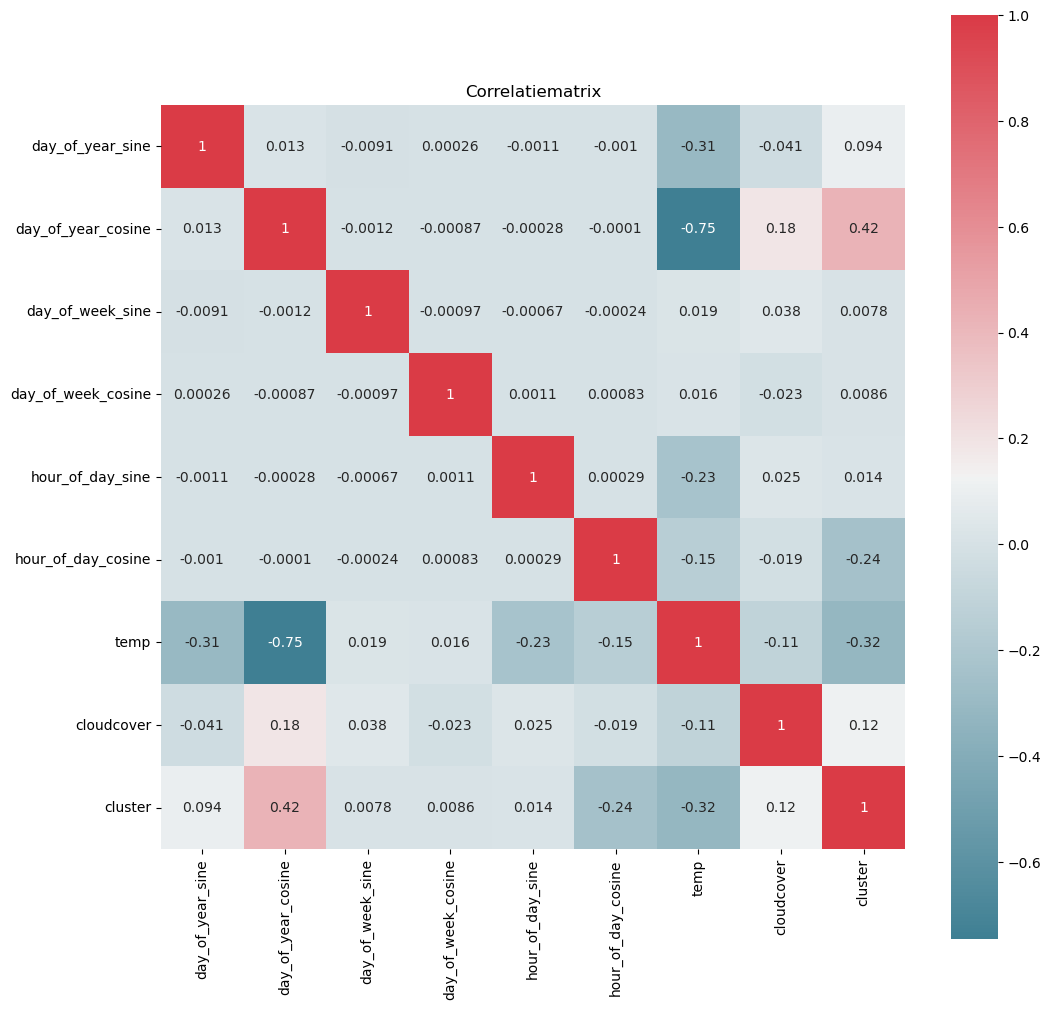

In [38]:
# Plotten van een heatmap om de correlatie tussen de features te visualiseren
f, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot=True)
plt.title("Correlatiematrix")

## Classifiecatiemodel trainen (model-selectie)

### Prepocessen van de data

In [54]:
# Eén maand opzij zetten als finale testset
df_test = df.tail(1000)
df = df.head(-1000)

In [55]:
# Splits de dataset in een trainings- en testset
y = df['cluster']
X = df.drop(['cluster'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train set class distribution:
cluster
0    0.697131
1    0.221079
2    0.081791
Name: proportion, dtype: float64


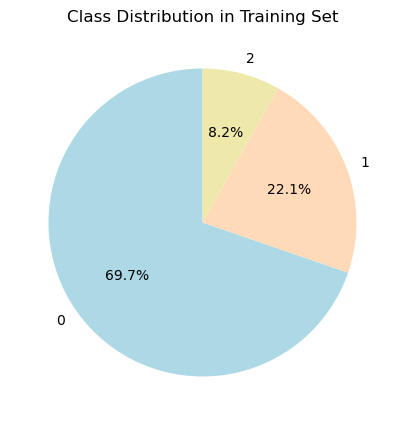

In [56]:
# Gebalanceerdheid van de klassen controleren
print("Train set class distribution:")
class_distribution = y_train.value_counts(normalize=True)
print(class_distribution)
plt.figure(figsize=(5, 5))
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'peachpuff', 'palegoldenrod'])
plt.title('Class Distribution in Training Set')
plt.ylabel('')
plt.show()

cluster
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64
cluster
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


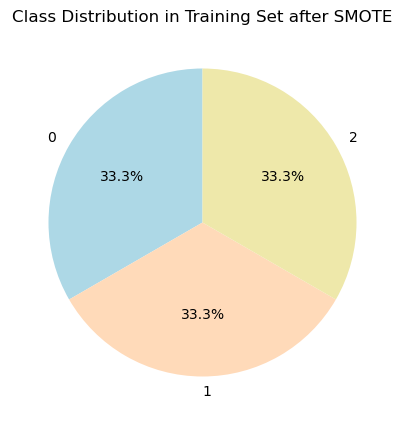

In [57]:
# Onbalanse klassen oplossen met SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_test_balanced, y_test_balanced = smote.fit_resample(X_test, y_test)
class_distribution = y_train_balanced.value_counts(normalize=True)
print(class_distribution)
print(class_distribution)
plt.figure(figsize=(5, 5))
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'peachpuff', 'palegoldenrod'])
plt.title('Class Distribution in Training Set after SMOTE')
plt.ylabel('')
plt.show()

In [58]:
# De gegevens schalen, aangezien we de outliers hebben verwijderd, kunnen we de MinMaxScaler gebruiken
scaler_consumption = MinMaxScaler()
scaler_consumption.fit(X_train)
X_train_balanced = scaler_consumption.transform(X_train_balanced)
X_test_balanced = scaler_consumption.transform(X_test_balanced)
X_test = scaler_consumption.transform(X_test)

### Trainen van het model

In [59]:
# Verschillende hyperparameters uitproberen voor de Random Forest Regressor
estimators = [10, 50, 100, 150]
rf_depths = [2, 10, 20, 35, 40, 50]

In [60]:
best_score = 0
best_classifier = None
for estimator in estimators:
    for depth in rf_depths:
        wp_classifier = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=42)
        wp_classifier.fit(X_train_balanced, y_train_balanced)
        score = wp_classifier.score(X_test_balanced, y_test_balanced)
        if score > best_score:
            best_score = score
            best_classifier = wp_classifier
            print(f"New best score: {best_score} with {estimator} estimators and max depth {depth}")
            with open('models/wp_classifier.pkl', 'wb') as file:
                pickle.dump(best_classifier, file)

New best score: 0.6801839464882943 with 10 estimators and max depth 2
New best score: 0.8405797101449275 with 10 estimators and max depth 10
New best score: 0.8825947603121517 with 10 estimators and max depth 20
New best score: 0.8938823857302118 with 50 estimators and max depth 20
New best score: 0.8943701226309922 with 100 estimators and max depth 20
New best score: 0.8945094760312151 with 150 estimators and max depth 20
New best score: 0.8954849498327759 with 150 estimators and max depth 35


### Testen van het model op ongeziene data

In [61]:
# Inladen van de beste classifier
with open('models/wp_classifier.pkl', 'rb') as file:
    wp_classifier = pickle.load(file)

In [62]:
# Validatiegegevens voorbereiden
df_test.reset_index(drop=True, inplace=True)
y_test = df_test['cluster']
X_test = df_test.drop(['cluster'], axis=1)
X_test = scaler_consumption.transform(X_test)

In [63]:
# Voorspellingen maken met de beste classifier
y_pred = wp_classifier.predict(X_test)

In [64]:
# Confusiematrix en classificatierapport genereren
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[443 329  21]
 [ 21  28  13]
 [ 47  48  50]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.56      0.68       793
           1       0.07      0.45      0.12        62
           2       0.60      0.34      0.44       145

    accuracy                           0.52      1000
   macro avg       0.51      0.45      0.41      1000
weighted avg       0.78      0.52      0.61      1000



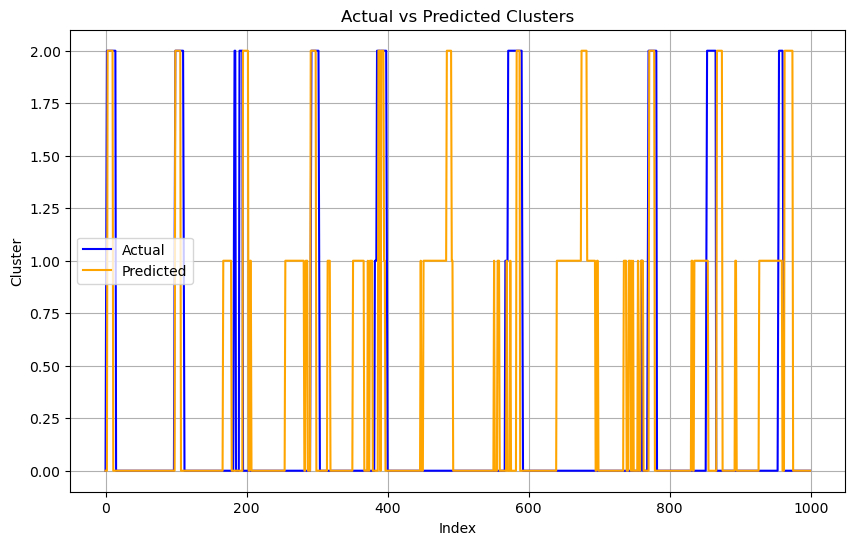

In [30]:
# Visualiseren van de voorspellingen
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('Cluster')
plt.title('Actual vs Predicted Clusters')
plt.legend()
plt.grid(True, which='both', axis='both')
plt.show()